# Structural Analysis

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scipy.stats as sps
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm

sns.set(font_scale=1.3)

In [2]:
DATA_PREFIX = os.path.join(os.pardir, 'data')
FIGURES_PREFIX = os.path.join(os.pardir, 'figures')

In [3]:
g = nx.read_gml(os.path.join(DATA_PREFIX, 'graph.gml'))

connected_components = list(nx.connected_components(g))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
g_sub = g.subgraph(biggest_cc)

## Comparison with random graphs

Let's look how ego-network is compared to random graph models:
* Erdos-Renyi
* Barabasi-Albert
* Watts-Strogatz

Remember our graph parameters:

In [4]:
def print_our_graph_parameters():
    average_length = nx.average_shortest_path_length(g_sub)
    print(f'Average path length: {average_length:.3f}')
    print(f'Clustering coefficient: {nx.average_clustering(g):.3f}')

In [5]:
print_our_graph_parameters()

Average path length: 3.499
Clustering coefficient: 0.577


In [6]:
degrees = np.array(list(dict(g.degree()).values()))
pd.Series(degrees).describe()

count    133.000000
mean      22.030075
std       14.189700
min        0.000000
25%       11.000000
50%       21.000000
75%       32.000000
max       53.000000
dtype: float64

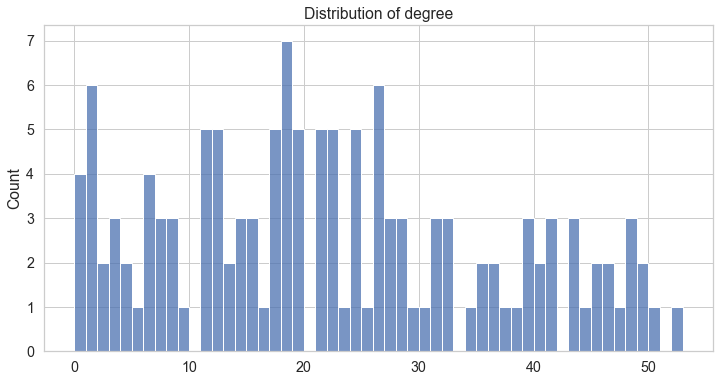

In [7]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    plt.show()

### Erdos-Renyi

It is random graph model.

First, let's try to fit a degree distribution. We will change many 

In [8]:
p_values = np.linspace(0, 0.5, 100) + 1e-3
num_trials = 1000
results = {'p': [], 'statistic': [],'seed': []}
for p in tqdm(p_values):
    for seed in range(num_trials):
        g_re = nx.erdos_renyi_graph(n=g.number_of_nodes(), p=p, seed=seed)
        degrees_temp = np.array(list(dict(g_re.degree()).values()))
        statistic = sps.ks_2samp(degrees, degrees_temp).statistic
        results['p'].append(p)
        results['statistic'].append(statistic)
        results['seed'].append(seed)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='statistic', ascending=True)

,p,statistic,seed
32582,0.162616,0.248120,582
33183,0.167667,0.248120,183
32183,0.162616,0.248120,183
31170,0.157566,0.255639,170
31515,0.157566,0.255639,515
...,...,...,...
99484,0.501000,1.000000,484
98710,0.495949,1.000000,710
99490,0.501000,1.000000,490
97895,0.490899,1.000000,895


In [10]:
best_p = results_df.sort_values(by='statistic', ascending=True).iloc[0]['p']
best_seed = int(results_df.sort_values(by='statistic', ascending=True).iloc[0]['seed'])
g_re = nx.erdos_renyi_graph(n=g.number_of_nodes(), p=best_p, seed=best_seed)

Now let's compare degree distributions visually.

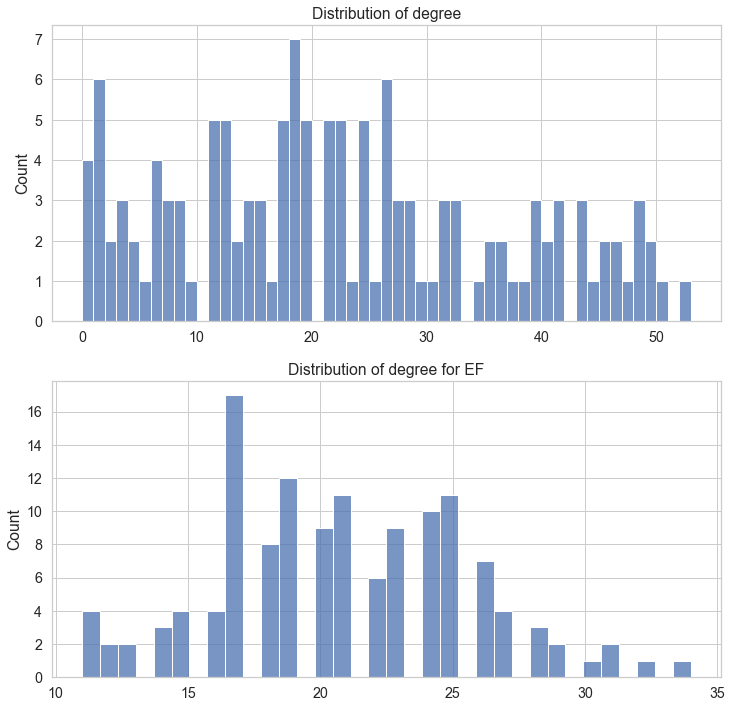

In [11]:
degrees_re = np.array(list(dict(g_re.degree()).values()))

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    
    plt.subplot(2, 1, 2)
    sns.histplot(degrees_re, bins=np.max(degrees_re))
    plt.title('Distribution of degree for EF')
    
    plt.show()

Distributions don't seem very similar.

Finally, let's compare average path len and clustering coefficient.

In [12]:
connected_components = list(nx.connected_components(g_re))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
g_re_sub = g_re.subgraph(biggest_cc)

average_length = nx.average_shortest_path_length(g_re_sub)
print(f'ER: Average path length: {average_length:.3f}')
print(f'ER: Clustering coefficient: {nx.average_clustering(g_re):.3f}')

print_our_graph_parameters()

ER: Average path length: 1.878
ER: Clustering coefficient: 0.158
Average path length: 3.499
Clustering coefficient: 0.577


Clustering coefficient differs drastically.

### Barabasi-Albert

It is preferential attachment model.

First, let's try to fit a degree distribution. We will change many 

In [13]:
m_values = np.arange(10, 16)
num_trials = 5000
results = {'m': [], 'statistic': [],'seed': []}
for m in tqdm(m_values):
    for seed in range(num_trials):
        g_ba = nx.barabasi_albert_graph(n=g.number_of_nodes(), m=m, seed=seed)
        degrees_temp = np.array(list(dict(g_ba.degree()).values()))
        statistic = sps.ks_2samp(degrees, degrees_temp).statistic
        results['m'].append(m)
        results['statistic'].append(statistic)
        results['seed'].append(seed)

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='statistic', ascending=True)

,m,statistic,seed
6304,11,0.203008,1304
5992,11,0.203008,992
9743,11,0.203008,4743
7247,11,0.203008,2247
6416,11,0.203008,1416
...,...,...,...
27811,15,0.330827,2811
25975,15,0.330827,975
25974,15,0.330827,974
27815,15,0.330827,2815


We see here a more good fit according to statistic.

In [15]:
best_m = int(results_df.sort_values(by='statistic', ascending=True).iloc[0]['m'])
best_seed = int(results_df.sort_values(by='statistic', ascending=True).iloc[0]['seed'])
g_ba = nx.barabasi_albert_graph(n=g.number_of_nodes(), m=best_m, seed=best_seed)

Now let's compare degree distributions visually.

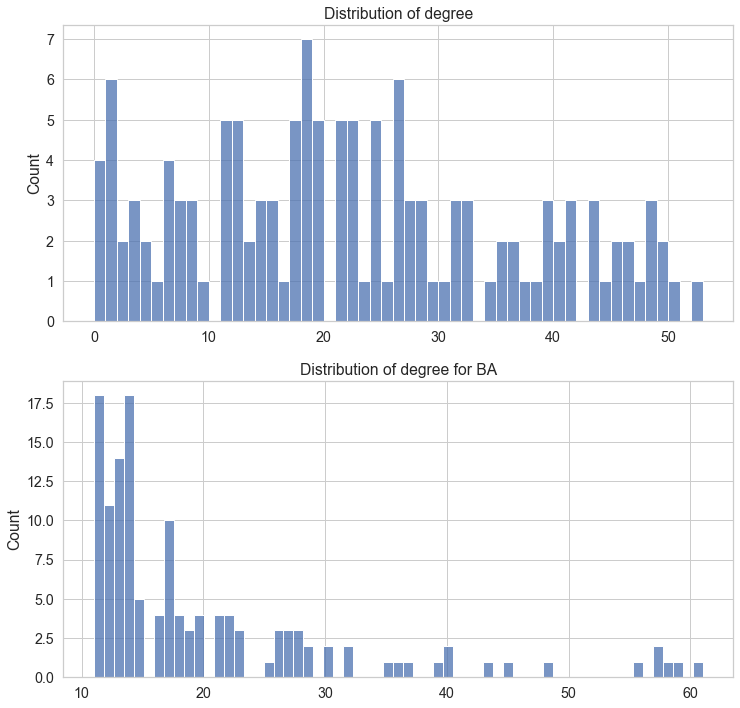

In [16]:
degrees_ba = np.array(list(dict(g_ba.degree()).values()))

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    
    plt.subplot(2, 1, 2)
    sns.histplot(degrees_ba, bins=np.max(degrees_ba))
    plt.title('Distribution of degree for BA')
    
    plt.show()

Distributions don't seem simiar around small values.

Finally, let's compare average path len and clustering coefficient.

In [17]:
connected_components = list(nx.connected_components(g_ba))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
g_ba_sub = g_ba.subgraph(biggest_cc)

average_length = nx.average_shortest_path_length(g_ba_sub)
print(f'BA: Average path length: {average_length:.3f}')
print(f'BA: Clustering coefficient: {nx.average_clustering(g_ba):.3f}')

print_our_graph_parameters()

BA: Average path length: 1.896
BA: Clustering coefficient: 0.253
Average path length: 3.499
Clustering coefficient: 0.577


Clustering coefficient looks better now.

### Watts-Strogatz

It is small world model.

First, let's try to fit a degree distribution. We will change many 

In [18]:
k_values = np.arange(20, 29, 2)
p_values = np.linspace(0, 0.5, 20) + 1e-3 
num_trials = 1000
results = {'k': [], 'p': [], 'statistic': [],'seed': []}
for k in tqdm(k_values):
    for p in p_values:
        for seed in range(num_trials):
            g_ws = nx.watts_strogatz_graph(n=g.number_of_nodes(), k=k, p=p, seed=seed)
            degrees_temp = np.array(list(dict(g_ws.degree()).values()))
            statistic = sps.ks_2samp(degrees, degrees_temp).statistic
            results['k'].append(k)
            results['p'].append(p)
            results['statistic'].append(statistic)
            results['seed'].append(seed)

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='statistic', ascending=True)

,k,p,statistic,seed
18783,20,0.474684,0.315789,783
18019,20,0.474684,0.315789,19
19442,20,0.501000,0.315789,442
19707,20,0.501000,0.315789,707
19545,20,0.501000,0.315789,545
...,...,...,...,...
80956,28,0.001000,0.684211,956
80957,28,0.001000,0.684211,957
80959,28,0.001000,0.684211,959
80323,28,0.001000,0.684211,323


We see here a more good fit according to statistic.

In [20]:
best_k = int(results_df.sort_values(by='statistic', ascending=True).iloc[0]['k'])
best_p = results_df.sort_values(by='statistic', ascending=True).iloc[0]['p']
best_seed = int(results_df.sort_values(by='statistic', ascending=True).iloc[0]['seed'])
g_ws = nx.watts_strogatz_graph(n=g.number_of_nodes(), k=best_k, p=best_p, seed=best_seed)

Now let's compare degree distributions visually.

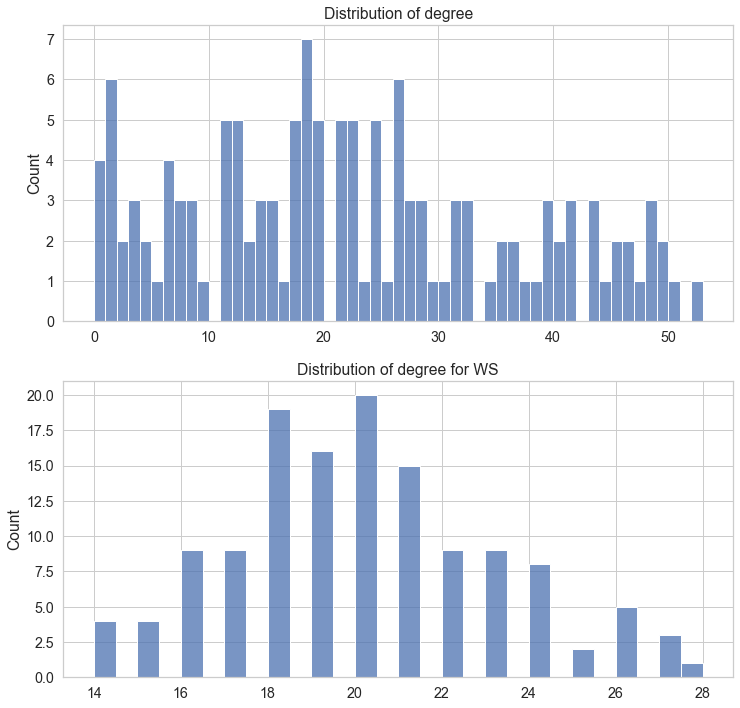

In [21]:
degrees_ws = np.array(list(dict(g_ws.degree()).values()))

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    
    plt.subplot(2, 1, 2)
    sns.histplot(degrees_ws, bins=np.max(degrees_ws))
    plt.title('Distribution of degree for WS')
    
    plt.show()

It Seems fine in general sense, but there are too small number of values.

Finally, let's compare average path len and clustering coefficient.

In [22]:
connected_components = list(nx.connected_components(g_ws))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
g_ws_sub = g_ws.subgraph(biggest_cc)

average_length = nx.average_shortest_path_length(g_ws_sub)
print(f'WS: Average path length: {average_length:.3f}')
print(f'WS: Clustering coefficient: {nx.average_clustering(g_ws):.3f}')

print_our_graph_parameters()

WS: Average path length: 1.898
WS: Clustering coefficient: 0.195
Average path length: 3.499
Clustering coefficient: 0.577


These parameters also don't fit well.

### Multiplot

Plot all four distributions on one canvas.

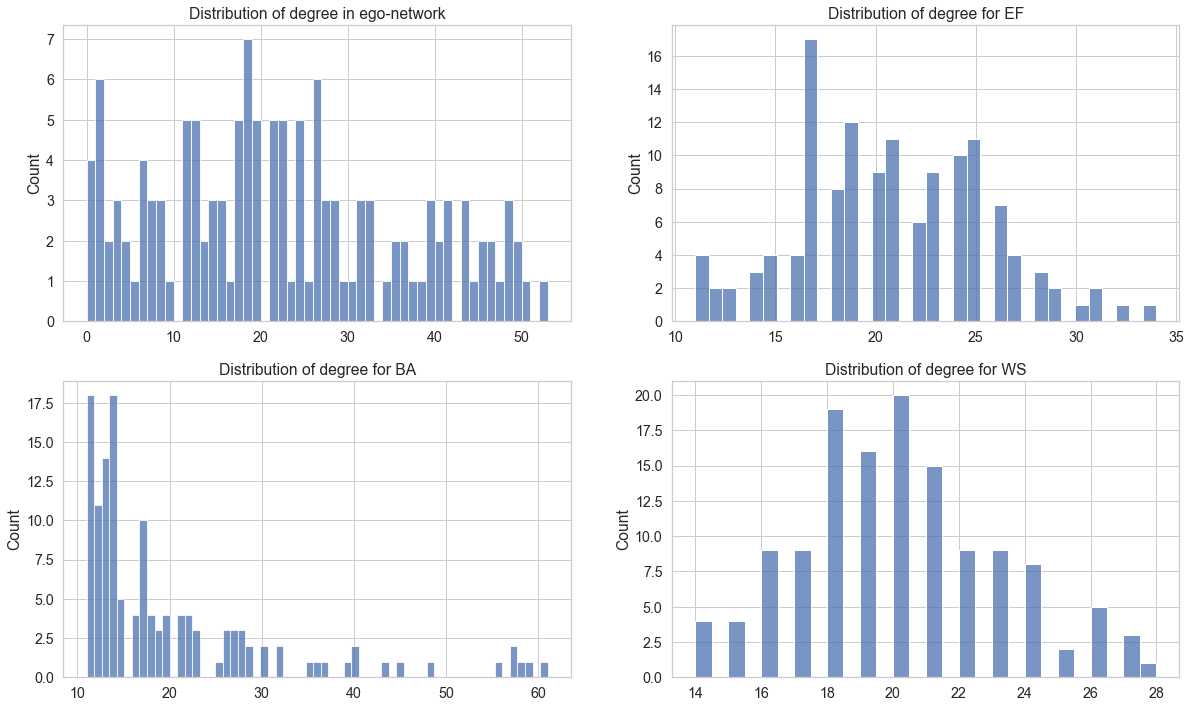

In [23]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree in ego-network')
    
    plt.subplot(2, 2, 2)
    sns.histplot(degrees_re, bins=np.max(degrees_re))
    plt.title('Distribution of degree for EF')
    
    plt.subplot(2, 2, 3)
    sns.histplot(degrees_ba, bins=np.max(degrees_ba))
    plt.title('Distribution of degree for BA')
    
    plt.subplot(2, 2, 4)
    sns.histplot(degrees_ws, bins=np.max(degrees_ws))
    plt.title('Distribution of degree for WS')
    
plt.savefig(os.path.join(FIGURES_PREFIX, 'degree distribution comparison.png'), bbox_inches='tight', dpi=300)
plt.show()

## Centralities and prestige

In this section we will measure centralities:
* Degree: proportional to number of neighbors
* Closeness: how close node to all other nodes
* Betweenness: number of shortest paths going through the node

And prestige Page-Rank.

### Degree

In [24]:
def visualize_centrality(g, centrality, centrality_name, scale=200, filename=None):
    plt.figure(figsize=(16, 9))
    layout = nx.kamada_kawai_layout(g)
    plt.title(f'Centrality visualization: {centrality_name}')
    nx.draw_networkx_nodes(g, pos=layout, node_color='#0066FF', node_size=[value*scale for key, value in centrality.items()])
    nx.draw_networkx_edges(g, pos=layout, alpha=0.1)
    plt.axis('off')
    if filename:
        plt.savefig(os.path.join(FIGURES_PREFIX, filename), bbox_inches='tight', dpi=300)
    plt.show()

In [25]:
def df_centrality(g, centrality):
    df = pd.DataFrame({'id': list(centrality.keys()), 'centrality': list(centrality.values())})
    df['firstname'] = df['id'].apply(lambda x: g.nodes(data=True)[x]['firstname'])
    df['lastname'] = df['id'].apply(lambda x: g.nodes(data=True)[x]['lastname'])
    return df

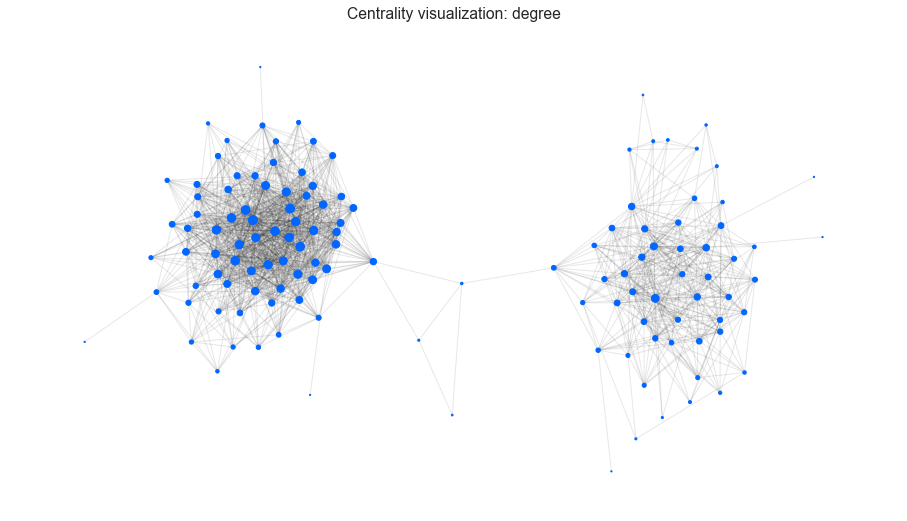

In [26]:
degree_centrality = nx.degree_centrality(g)
visualize_centrality(g, degree_centrality, 'degree', filename='centrality degree.png')

In [27]:
df_centrality(g, degree_centrality).sort_values(by='centrality', ascending=False).head(10)

,id,centrality,firstname,lastname
8,119706122,0.401515,Alexey,Podkidyshev
37,142927876,0.378788,Aygul,Gazimova
97,85020018,0.371212,Nikita,Pavlichenko
59,106745312,0.371212,Ekaterina,Shaydurova
60,99979546,0.363636,Ekaterina,Yushina
6,152861817,0.363636,Alexandra,Pogrebnaya
53,57504826,0.363636,Dmitry,Pavlov
77,151575458,0.356061,Ivan,Stolov
23,111141867,0.348485,Anna,Shavrina
126,147060343,0.348485,Yana,Mikhaylova


Top friends are people who knows a lot of my other friends. A lot of my friends are studying at the same department in MIPT, so top people have a lot of friends at DIHT MIPT.

### Closeness

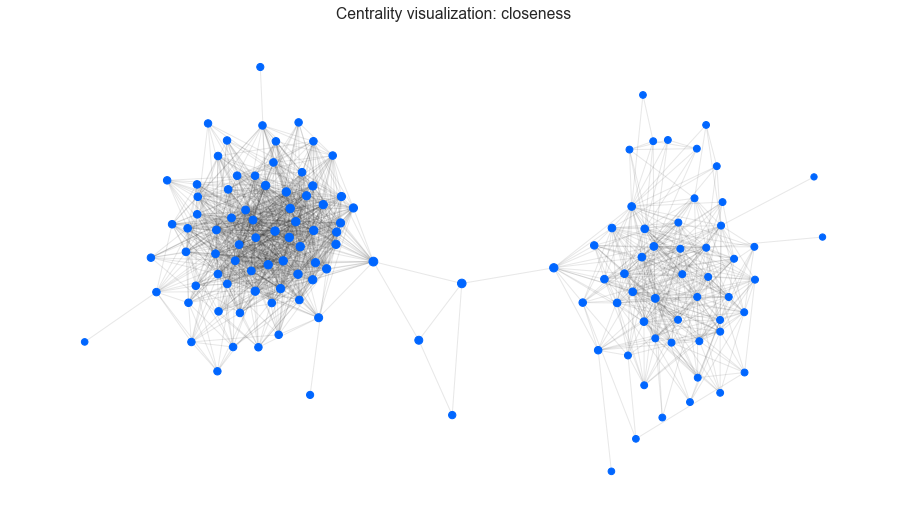

In [28]:
closeness_centrality = nx.closeness_centrality(g)
visualize_centrality(g, closeness_centrality, 'closeness', filename='centrality closeness.png')

We can see, that a lot of people has approximately the same centrality.

In [29]:
df_centrality(g, closeness_centrality).sort_values(by='centrality', ascending=False).head(10)

,id,centrality,firstname,lastname
99,167400208,0.385470,Nikita,Toroptsev
70,168342271,0.365062,Ilya,Potemin
59,106745312,0.350625,Ekaterina,Shaydurova
97,85020018,0.350625,Nikita,Pavlichenko
53,57504826,0.349637,Dmitry,Pavlov
77,151575458,0.348655,Ivan,Stolov
126,147060343,0.347678,Yana,Mikhaylova
74,3656763,0.346707,Ivan,Erlikh
122,184555115,0.345742,Vladislav,Terzi
86,114963238,0.344781,Konstantin,Morozov


There are two big groups on the graph:
1. University friends.
2. School friends.

I expected these two groups to be not connected (I studied at small average school), but somehow there is connection through one person, who knows person from my school and from my university. So, two people, who at the top of the list are in the middle of this connection.

### Betwenness

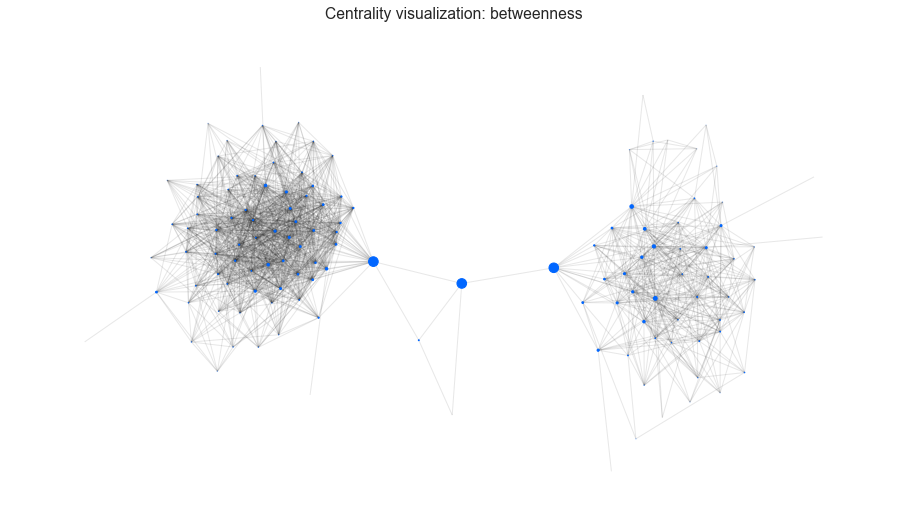

In [30]:
betweenness_centrality = nx.betweenness_centrality(g)
visualize_centrality(g, betweenness_centrality, 'betweenness', filename='centrality betweenness.png')

As expected, there are few nodes with very big centrality, because they connect two subgraphs.

In [31]:
df_centrality(g, betweenness_centrality).sort_values(by='centrality', ascending=False).head(10)

,id,centrality,firstname,lastname
99,167400208,0.466954,Nikita,Toroptsev
70,168342271,0.463972,Ilya,Potemin
84,261788342,0.457979,Kirill,Zakhmatov
1,124870072,0.072187,Alexander,Drozhzhin
129,137744206,0.063050,Yury,Bunin
7,151328814,0.050525,Alexey,Bunin
113,368572319,0.035554,Tatyana,Bunina
74,3656763,0.031566,Ivan,Erlikh
54,127720125,0.030649,Dmitry,Proskurin
65,220550501,0.029868,Fedor,Noskov


Explanation remains from the last section, but now it is more obvious.

### Page-Rank

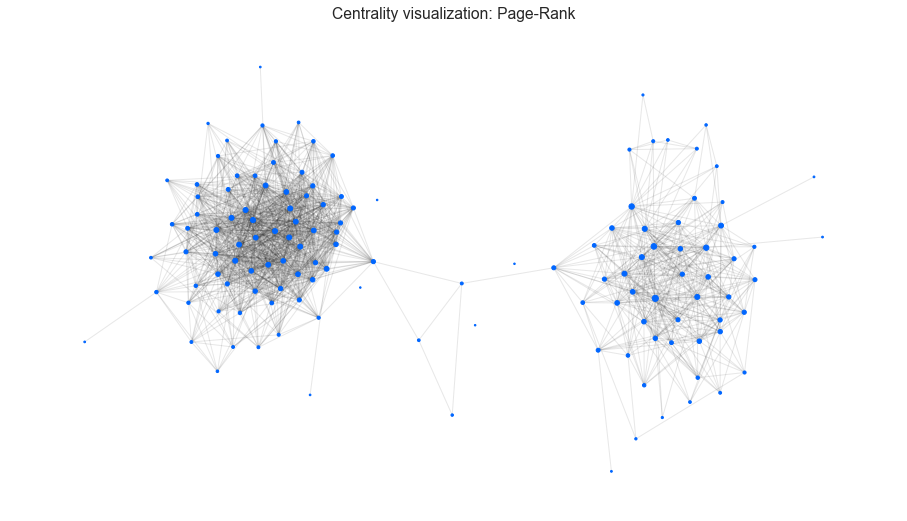

In [32]:
page_rank = nx.pagerank(g, max_iter=1000, alpha=0.85)
visualize_centrality(g, page_rank, 'Page-Rank', scale=2000, filename='centrality page-rank.png')

As expected, there are few nodes with very big centrality, because they connect two subgraphs.

In [33]:
df_centrality(g, page_rank).sort_values(by='centrality', ascending=False).head(10)

,id,centrality,firstname,lastname
1,124870072,0.018693,Alexander,Drozhzhin
7,151328814,0.015539,Alexey,Bunin
129,137744206,0.014377,Yury,Bunin
43,163545843,0.013987,Danil,Kirov
8,119706122,0.013290,Alexey,Podkidyshev
37,142927876,0.012536,Aygul,Gazimova
113,368572319,0.012502,Tatyana,Bunina
97,85020018,0.012384,Nikita,Pavlichenko
130,158927900,0.012300,Yury,Petrov
60,99979546,0.012278,Ekaterina,Yushina


The result is rather surprising: top 3 people are person from my school and relatives. I think that they can be though as some kind of dead end nodes.

### Correlation

Let's look at the correlations of centralities and prestige. I want to use Kendall coefficient, because it is using ranks rather that plain values.

In [34]:
df_centvals = pd.DataFrame({'id': list(degree_centrality.keys()), 'degree': list(degree_centrality.values())})
df_centvals['closeness'] = df_centvals['id'].apply(lambda x: closeness_centrality[x])
df_centvals['betweenness'] = df_centvals['id'].apply(lambda x: betweenness_centrality[x])
df_centvals['page_rank'] = df_centvals['id'].apply(lambda x: page_rank[x])

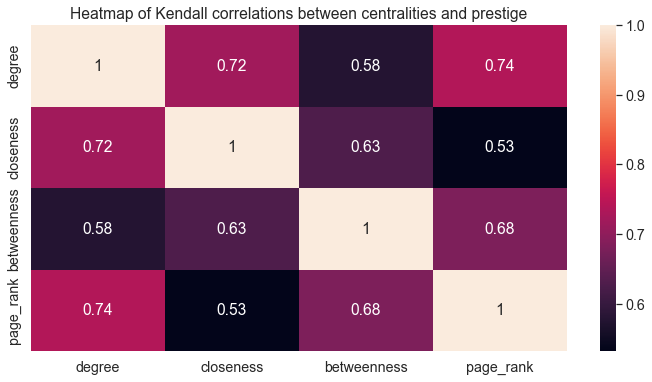

In [35]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_centvals.corr('kendall'), annot=True)
plt.title('Heatmap of Kendall correlations between centralities and prestige')
plt.savefig(os.path.join(FIGURES_PREFIX, 'correlation centralities'), bbox_inches='tight', dpi=300)
plt.show()

We can see that the biggest difference with betweenness centrality. Probably, it is because of that bridge. According to betweenness, the biggest centrality will get people, who are closer to the bridge, than to the center of the clusters.

Other values are quite similar.

## Assortative mixing

We will look at properties:
* sex
* city
* university

In [36]:
def get_mixing_matrix(g, attribute):
    values = set()
    for node, node_data in g.nodes(data=True):
        values.add(node_data[attribute])
    mapping = {value: i for i, value in enumerate(values)}
    return nx.attribute_mixing_matrix(g, attribute, mapping=mapping), mapping

In [37]:
def plot_mixing_matrix(matrix, mapping, attribute, annot=False):
    plt.figure(figsize=(12, 6))
    labels = [x for x in mapping]
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=annot)
    plt.title(f'Assortative mixing by {attribute}')
    plt.savefig(os.path.join(FIGURES_PREFIX, f'assortative mixing {attribute}.png'), bbox_inches='tight', dpi=300)
    plt.show()

### Sex

In [38]:
sex_matrix, sex_mapping = get_mixing_matrix(g, 'sex')

In [39]:
values = [values['sex'] for key, values in g.nodes(data=True)]
np.unique(values, return_counts=True)

(array(['female', 'male'], dtype='<U6'), array([ 30, 103]))

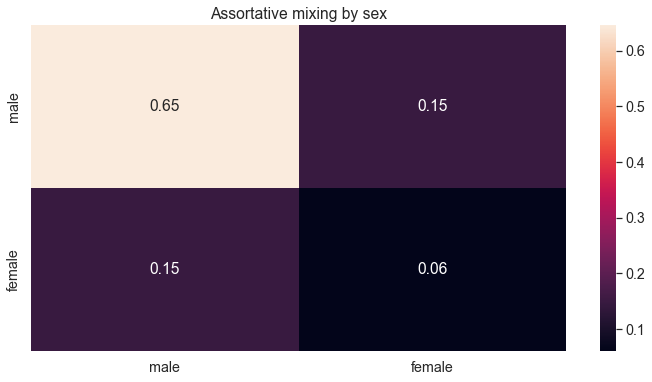

In [40]:
plot_mixing_matrix(sex_matrix, sex_mapping, 'sex', annot=True)

* There are more male friends
* They have a connection much more often

### City

In [41]:
city_matrix, city_mapping = get_mixing_matrix(g, 'city')

In [42]:
values = [values['city'] for key, values in g.nodes(data=True)]
values, counts = np.unique(values, return_counts=True)
sort_idx = np.argsort(-counts)
for value, count in zip(values[sort_idx], counts[sort_idx]):
    print(f'Value: {value}, count: {count}')

Value: Moscow, count: 42
Value: None, count: 34
Value: Penza, count: 21
Value: Dolgoprudny, count: 10
Value: Mokshan, count: 10
Value: Saint Petersburg, count: 2
Value: Tolyatti, count: 2
Value: Tula, count: 2
Value: Kharkiv, count: 1
Value: Nizhny Lomov, count: 1
Value: Izhevsk, count: 1
Value: Omsk, count: 1
Value: Chicago, count: 1
Value: Petrozavodsk, count: 1
Value: Cherepovets, count: 1
Value: Saratov, count: 1
Value: Mineralnye Vody, count: 1
Value: Bryansk, count: 1


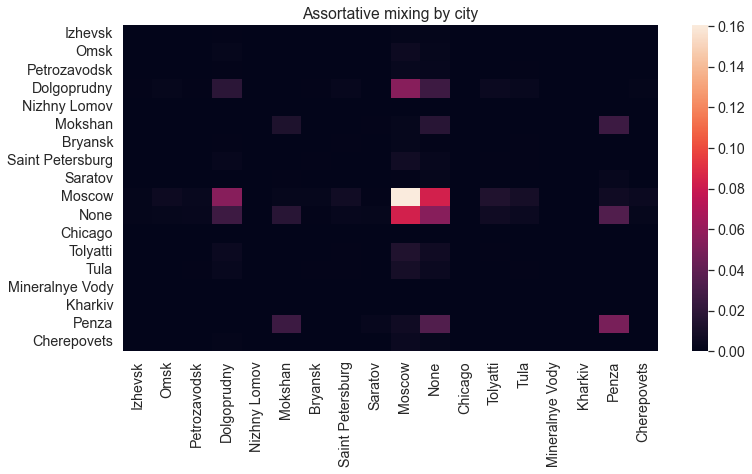

In [43]:
plot_mixing_matrix(city_matrix, city_mapping, 'city')

We can see a strong connection in Moscow. I think it is mostly related to university.

### University

In [44]:
university_matrix, university_mapping = get_mixing_matrix(g, 'university')

In [45]:
values = [values['university'] for key, values in g.nodes(data=True)]
values, counts = np.unique(values, return_counts=True)
sort_idx = np.argsort(-counts)
for value, count in zip(values[sort_idx], counts[sort_idx]):
    print(f'Value: {value}, count: {count}')

Value: None, count: 54
Value: МФТИ, count: 47
Value: ПИ им. Белинского ПГУ (бывш. ПГПУ), count: 6
Value: МГУ, count: 5
Value: ПГУАС (ПГАСА), count: 3
Value: ПГПУ им. Белинского, count: 2
Value: МГПИ (ныне МГПУ), count: 1
Value: НИ МГУ им. Огарева, count: 1
Value: НИУ ВШЭ (ГУ-ВШЭ), count: 1
Value: ПГАУ (бывш. ПГСХА), count: 1
Value: СамГМУ, count: 1
Value: ПГУ, count: 1
Value: МГИК (бывш. МГУКИ), count: 1
Value: Northwestern University, count: 1
Value: ППИ (бывш. ПГПУ) им. Белинского, count: 1
Value: РГУ нефти и газа (НИУ) им. И. М. Губкина, count: 1
Value: РУДН, count: 1
Value: РЭУ им. Г. В. Плеханова, count: 1
Value: СГМУ им. В. И. Разумовского, count: 1
Value: СГЮА (бывш. СГАП, СГЮИ им. Д. И. Курского), count: 1
Value: МПГУ (бывш. МГПИ им. Ленина), count: 1
Value: Университет «Иннополис», count: 1


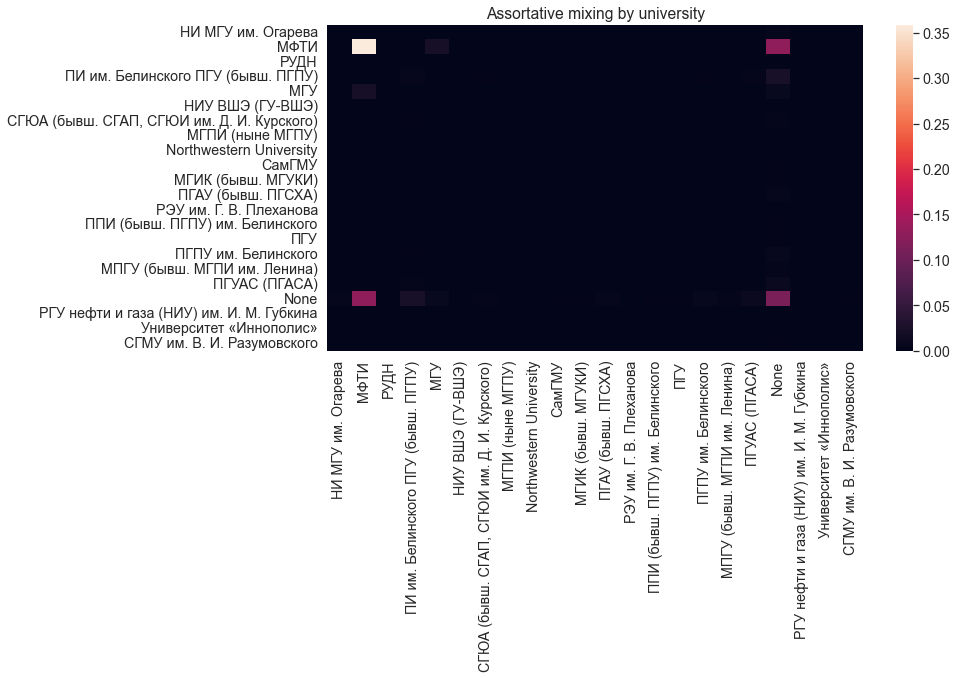

In [46]:
plot_mixing_matrix(university_matrix, university_mapping, 'university')

* There is a strong connection only withing MIPT

## Similarities

Now we are going to look at similarities between different nodes:
* Adjacency matrix
* Pearson correlation
* Jaccard similarity
* Cosine similarity

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee


def sim_matrices(G):
    A = nx.to_numpy_array(G)
    corr = np.corrcoef(A)
    J = np.zeros(A.shape)
    for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        J[i, j] = c
        J[j, i] = c
    cos = cosine_similarity(A)
    return A, corr, J, cos

def cm_order(G):
    A = nx.to_numpy_array(G)
    return reverse_cuthill_mckee(csr_matrix(A), symmetric_mode=True)

In [49]:
A, corr, J, cos = sim_matrices(g)
order = cm_order(g)

/home/mrgeekman/Documents/MIPT/САиВС/Project/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mrgeekman/Documents/MIPT/САиВС/Project/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


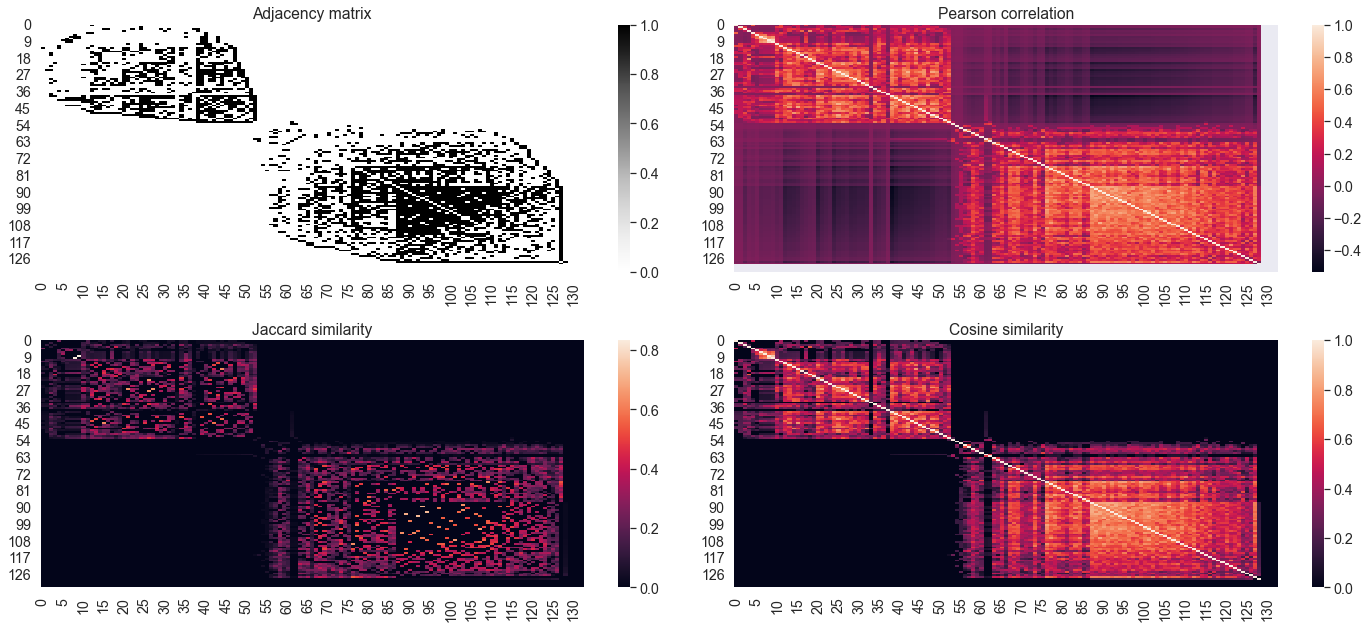

In [50]:
plt.figure(figsize=(20, 9))

plt.subplot(2, 2, 1)
sns.heatmap(A[np.ix_(order, order)], cmap=plt.cm.Greys)
plt.title('Adjacency matrix')

plt.subplot(2, 2, 2)
sns.heatmap(corr[np.ix_(order, order)])
plt.title('Pearson correlation')

plt.subplot(2, 2, 3)
sns.heatmap(J[np.ix_(order, order)])
plt.title('Jaccard similarity')

plt.subplot(2, 2, 4)
sns.heatmap(cos[np.ix_(order, order)])
plt.title('Cosine similarity')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PREFIX, f'similarities.png'), bbox_inches='tight', dpi=300)
plt.show()

Let's look at pairs with highest correlation.

In [51]:
def get_df_similarities(similarity):
    result_dict = {'first': [], 'second': [], 'similarity': []}
    for i in range(similarity.shape[0]):
        for j in range(i):
            result_dict['similarity'].append(similarity[i, j])
            
            first_dict = list(g.nodes(data=True))[i][1]
            result_dict['first'].append(f"{first_dict['firstname']} {first_dict['lastname']}")
            
            second_dict = list(g.nodes(data=True))[j][1]
            result_dict['second'].append(f"{second_dict['firstname']} {second_dict['lastname']}")
            
    return pd.DataFrame(result_dict)

In [52]:
get_df_similarities(corr).sort_values(by='similarity', ascending=False).head(10)

,first,second,similarity
592,Artyom Pogorelsky,Artem Pogorelsky,0.909298
4691,Nikita Pavlichenko,Artyom Yamalutdinov,0.774877
5885,Ruslan Gornaev,Roman Ivantsov,0.774439
3921,Lyudmila Bunina,Alexandra Arbekova,0.759935
7934,Yana Mikhaylova,Ekaterina Shaydurova,0.755433
2979,Ivan Stolov,Dmitry Pavlov,0.754502
6874,Valeria Scherbakova,Ksenia Grishina,0.747609
3198,Kirill Ivantsov,Boris Metyolkin,0.744656
727,Boris Metyolkin,Anton Ezhkov,0.744656
672,Aygul Gazimova,Alexandra Pogrebnaya,0.741947


* First two positions is a page of the same relative (he lost credentials for one of them)
* There are some relatves with little social network activities
* There are two people from my town
* There are some university friends from the same study group

In [53]:
get_df_similarities(J).sort_values(by='similarity', ascending=False).head(10)

,first,second,similarity
592,Artyom Pogorelsky,Artem Pogorelsky,0.833333
2979,Ivan Stolov,Dmitry Pavlov,0.727273
4662,Nikita Pavlichenko,Alexandra Pogrebnaya,0.701754
1506,Egor Bedrinsky,Anna Gavrikova,0.666667
693,Aygul Gazimova,Artem Alexandrov,0.636364
3198,Kirill Ivantsov,Boris Metyolkin,0.636364
727,Boris Metyolkin,Anton Ezhkov,0.636364
7417,Vladislav Terzi,Arutyun Barsegyan,0.632653
1797,Ekaterina Yushina,Artem Alexandrov,0.629630
6874,Valeria Scherbakova,Ksenia Grishina,0.625000


There are more university friends and fewer relatives.

In [54]:
get_df_similarities(cos).sort_values(by='similarity', ascending=False).head(10)

,first,second,similarity
592,Artyom Pogorelsky,Artem Pogorelsky,0.912871
4691,Nikita Pavlichenko,Artyom Yamalutdinov,0.846392
7934,Yana Mikhaylova,Ekaterina Shaydurova,0.842525
2979,Ivan Stolov,Dmitry Pavlov,0.842152
672,Aygul Gazimova,Alexandra Pogrebnaya,0.836909
1778,Ekaterina Yushina,Alexey Podkidyshev,0.832704
1386,Dmitry Pavlov,Alexey Podkidyshev,0.832704
4709,Nikita Pavlichenko,Dmitry Pavlov,0.824786
4662,Nikita Pavlichenko,Alexandra Pogrebnaya,0.824786
4664,Nikita Pavlichenko,Alexey Podkidyshev,0.824163


The picture is closer to Jaccard similarity.